<a href="https://colab.research.google.com/github/adas-quant/mscfe-gwp1-yieldcurve/blob/arindam-task2/notebooks/02_Task2_YieldCurve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2 — Yield Curve Modeling

## Objective
- Pick government securities from one country(India)
- Fit Nelson-Siegel model.
- Fit Cubic-Spline model.
- Compare models in terms of fit & interpretation.
- Discuss smoothing vs. ethics.


In [ ]:
import pandas as pd

# Example: scrape CCIL tenor-wise yields (they might publish via HTML table)
url = "https://www.ccilindia.com/web/ccil/tenorwise-indicative-yields"
tables = pd.read_html(url)   # this yields a list of DataFrames
for i, tab in enumerate(tables):
    print("Table", i)
    print(tab.head())


Table 0
                    Date Tenor Bucket              Security  YTM (%)
0  2025-10-01 00:00:00.0          91D   91 DTB (02/01/2026)   5.4881
1  2025-10-01 00:00:00.0         182D  182 DTB (03/04/2026)   5.5899
2  2025-10-01 00:00:00.0         364D  364 DTB (02/10/2026)   5.5999
3  2025-10-01 00:00:00.0        1Y-2Y         7.38% GS 2027   5.7975
4  2025-10-01 00:00:00.0        4Y-5Y         6.01% GS 2030   6.1500


In [ ]:
import pandas as pd

# CCIL tenor-wise yields URL
url = "https://www.ccilindia.com/web/ccil/tenorwise-indicative-yields"

# Read all HTML tables
tables = pd.read_html(url)

# Pick the first table (the one with yields)
table = tables[0]

# Display full table without truncation
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

print(table)


                     Date Tenor Bucket                Security  YTM (%)
0   2025-10-03 00:00:00.0          91D     91 DTB (02/01/2026)   5.4881
1   2025-10-03 00:00:00.0         182D    182 DTB (03/04/2026)   5.5899
2   2025-10-03 00:00:00.0         364D    364 DTB (02/10/2026)   5.5999
3   2025-10-03 00:00:00.0        1Y-2Y           7.38% GS 2027   5.6511
4   2025-10-03 00:00:00.0        4Y-5Y           6.01% GS 2030   6.1066
5   2025-10-03 00:00:00.0       9Y-10Y           6.33% GS 2035   6.5104
6   2025-10-03 00:00:00.0      13Y-15Y           6.68% GS 2040   6.8047
7   2025-10-03 00:00:00.0      28Y-30Y           7.24% GS 2055   7.1218
8   2025-10-03 00:00:00.0           5Y  7.30% UTTARAKHAND 2032   7.3000
9   2025-10-03 00:00:00.0          10Y          7.37% GOA 2036   7.3700
10  2025-10-03 00:00:00.0          15Y       7.49% KERALA 2040   7.4900


In [ ]:
import pandas as pd

# Load CCIL table
url = "https://www.ccilindia.com/web/ccil/tenorwise-indicative-yields"
tables = pd.read_html(url)
df = tables[0]

# Display raw table
df.head(15)


,Date,Tenor Bucket,Security,YTM (%)
0,2025-10-03 00:00:00.0,91D,91 DTB (02/01/2026),5.4881
1,2025-10-03 00:00:00.0,182D,182 DTB (03/04/2026),5.5899
2,2025-10-03 00:00:00.0,364D,364 DTB (02/10/2026),5.5999
3,2025-10-03 00:00:00.0,1Y-2Y,7.38% GS 2027,5.6511
4,2025-10-03 00:00:00.0,4Y-5Y,6.01% GS 2030,6.1066
5,2025-10-03 00:00:00.0,9Y-10Y,6.33% GS 2035,6.5104
6,2025-10-03 00:00:00.0,13Y-15Y,6.68% GS 2040,6.8047
7,2025-10-03 00:00:00.0,28Y-30Y,7.24% GS 2055,7.1218
8,2025-10-03 00:00:00.0,5Y,7.30% UTTARAKHAND 2032,7.3000
9,2025-10-03 00:00:00.0,10Y,7.37% GOA 2036,7.3700


In [16]:
# Keep rows where 'Security' contains 'GS' or 'DTB' (T-Bills)
df_gs = df[df['Security'].str.contains("GS|DTB", case=False, na=False)].copy()

df_gs


,Date,Tenor Bucket,Security,YTM (%)
0,2025-10-03 00:00:00.0,91D,91 DTB (02/01/2026),5.4881
1,2025-10-03 00:00:00.0,182D,182 DTB (03/04/2026),5.5899
2,2025-10-03 00:00:00.0,364D,364 DTB (02/10/2026),5.5999
3,2025-10-03 00:00:00.0,1Y-2Y,7.38% GS 2027,5.6511
4,2025-10-03 00:00:00.0,4Y-5Y,6.01% GS 2030,6.1066
5,2025-10-03 00:00:00.0,9Y-10Y,6.33% GS 2035,6.5104
6,2025-10-03 00:00:00.0,13Y-15Y,6.68% GS 2040,6.8047
7,2025-10-03 00:00:00.0,28Y-30Y,7.24% GS 2055,7.1218


In [15]:
# Mapping tenor buckets to approx years

tenor_map = {
    "91D": 0.25,
    "182D": 0.5,
    "364D": 1,
    "1Y-2Y": 2,       # approx expiry in 2027
    "4Y-5Y": 5,       # 2030
    "9Y-10Y": 10,     # 2035
    "13Y-15Y": 15,    # 2040
    "28Y-30Y": 30     # 2055
}



# Add "Years" column
df_gs["Years"] = df_gs["Tenor Bucket"].map(tenor_map)

# Drop rows where we don’t have mapping
df_curve = df_gs.dropna(subset=["Years"]).copy()

df_curve


,Date,Tenor Bucket,Security,YTM (%),Years
0,2025-10-03 00:00:00.0,91D,91 DTB (02/01/2026),5.4881,0.25
1,2025-10-03 00:00:00.0,182D,182 DTB (03/04/2026),5.5899,0.50
2,2025-10-03 00:00:00.0,364D,364 DTB (02/10/2026),5.5999,1.00
3,2025-10-03 00:00:00.0,1Y-2Y,7.38% GS 2027,5.6511,2.00
4,2025-10-03 00:00:00.0,4Y-5Y,6.01% GS 2030,6.1066,5.00
5,2025-10-03 00:00:00.0,9Y-10Y,6.33% GS 2035,6.5104,10.00
6,2025-10-03 00:00:00.0,13Y-15Y,6.68% GS 2040,6.8047,15.00
7,2025-10-03 00:00:00.0,28Y-30Y,7.24% GS 2055,7.1218,30.00


In [17]:
yield_curve = df_curve[["Date", "Years", "YTM (%)"]].sort_values("Years")

yield_curve


,Date,Years,YTM (%)
0,2025-10-03 00:00:00.0,0.25,5.4881
1,2025-10-03 00:00:00.0,0.50,5.5899
2,2025-10-03 00:00:00.0,1.00,5.5999
3,2025-10-03 00:00:00.0,2.00,5.6511
4,2025-10-03 00:00:00.0,5.00,6.1066
5,2025-10-03 00:00:00.0,10.00,6.5104
6,2025-10-03 00:00:00.0,15.00,6.8047
7,2025-10-03 00:00:00.0,30.00,7.1218


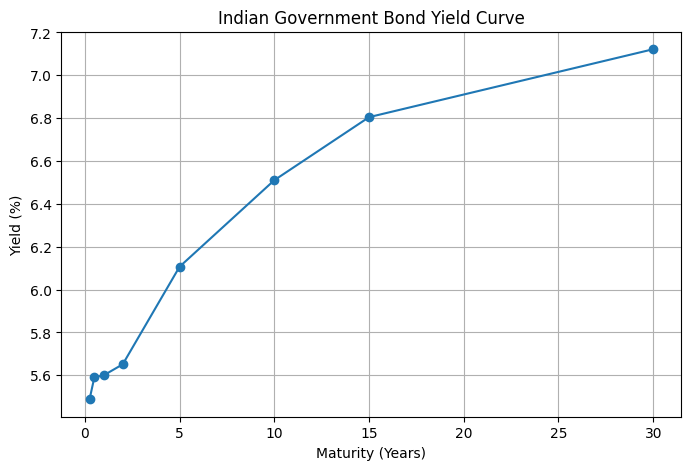

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(yield_curve["Years"], yield_curve["YTM (%)"], marker="o")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Indian Government Bond Yield Curve")
plt.grid(True)
plt.show()


In [19]:
import os
from datetime import datetime

# Ensure the folder exists
os.makedirs("data/processed", exist_ok=True)

# Format filename as yieldcurve_YYYYMMDD.csv
today = datetime.today().strftime("%Y%m%d")
filename = f"data/processed/yieldcurve_{today}.csv"

# Save clean curve
yield_curve.to_csv(filename, index=False)

print("Saved:", filename)


Saved: data/processed/yieldcurve_20251003.csv


In [20]:
import pandas as pd

# Load the cleaned yield curve
filename = "data/processed/yieldcurve_20251003.csv"  # replace with actual date
yield_curve = pd.read_csv(filename)

yield_curve


,Date,Years,YTM (%)
0,2025-10-03 00:00:00.0,0.25,5.4881
1,2025-10-03 00:00:00.0,0.50,5.5899
2,2025-10-03 00:00:00.0,1.00,5.5999
3,2025-10-03 00:00:00.0,2.00,5.6511
4,2025-10-03 00:00:00.0,5.00,6.1066
5,2025-10-03 00:00:00.0,10.00,6.5104
6,2025-10-03 00:00:00.0,15.00,6.8047
7,2025-10-03 00:00:00.0,30.00,7.1218


In [23]:
import numpy as np

def nelson_siegel(t, beta0, beta1, beta2, tau):
    term1 = (1 - np.exp(-t/tau)) / (t/tau)
    term2 = term1 - np.exp(-t/tau)
    return beta0 + beta1*term1 + beta2*term2


In [24]:
from scipy.optimize import curve_fit

t = yield_curve["Years"].values
y = yield_curve["YTM (%)"].values

# Initial guesses for beta0, beta1, beta2, tau
p0 = [y[-1], -1, 1, 1]  # rough guesses

params, covariance = curve_fit(nelson_siegel, t, y, p0=p0)

beta0, beta1, beta2, tau = params
print("Nelson-Siegel parameters:")
print("beta0:", beta0, "beta1:", beta1, "beta2:", beta2, "tau:", tau)

# Standard errors
std_errors = np.sqrt(np.diag(covariance))
print("Standard errors:", std_errors)


Nelson-Siegel parameters:
beta0: 7.444395168160836 beta1: -1.938101912607706 beta2: -1.6200408460589535 tau: 2.7506651673269853
Standard errors: [0.08519904 0.10884588 0.37401069 0.53953212]


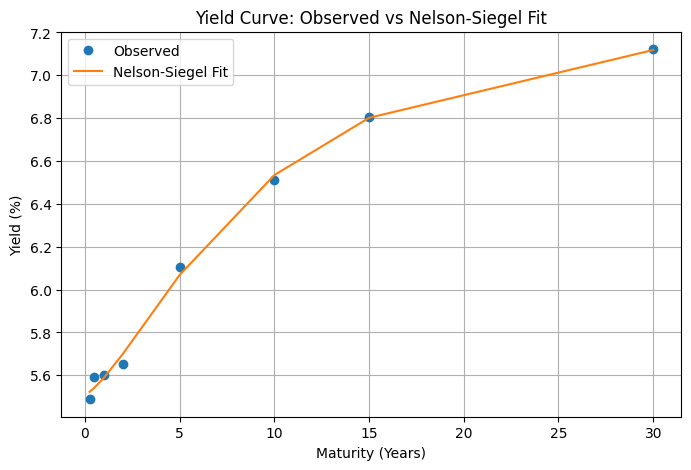

In [25]:
y_fit = nelson_siegel(t, *params)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(t, y, 'o', label='Observed')
plt.plot(t, y_fit, '-', label='Nelson-Siegel Fit')
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Yield Curve: Observed vs Nelson-Siegel Fit")
plt.legend()
plt.grid(True)
plt.show()


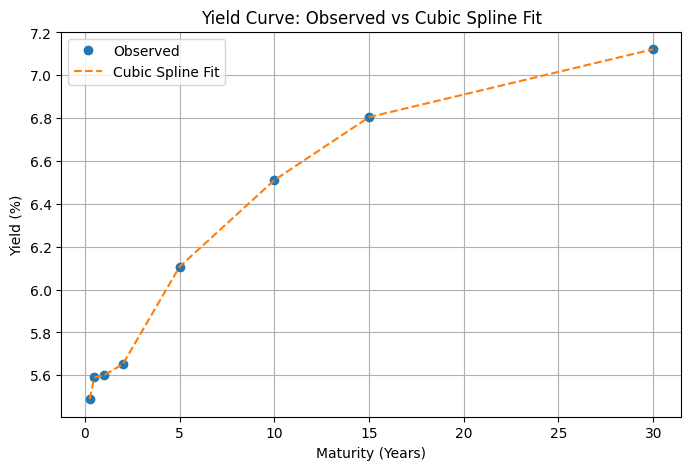

In [26]:
from scipy.interpolate import CubicSpline

cs = CubicSpline(t, y)
y_spline = cs(t)

plt.figure(figsize=(8,5))
plt.plot(t, y, 'o', label='Observed')
plt.plot(t, y_spline, '--', label='Cubic Spline Fit')
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Yield Curve: Observed vs Cubic Spline Fit")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_ns = np.sqrt(mean_squared_error(y, y_fit))
mae_ns = mean_absolute_error(y, y_fit)

rmse_cs = np.sqrt(mean_squared_error(y, y_spline))
mae_cs = mean_absolute_error(y, y_spline)

print(f"Nelson-Siegel RMSE: {rmse_ns:.4f}, MAE: {mae_ns:.4f}")
print(f"Cubic Spline RMSE: {rmse_cs:.4f}, MAE: {mae_cs:.4f}")


Nelson-Siegel RMSE: 0.0317, MAE: 0.0265
Cubic Spline RMSE: 0.0000, MAE: 0.0000


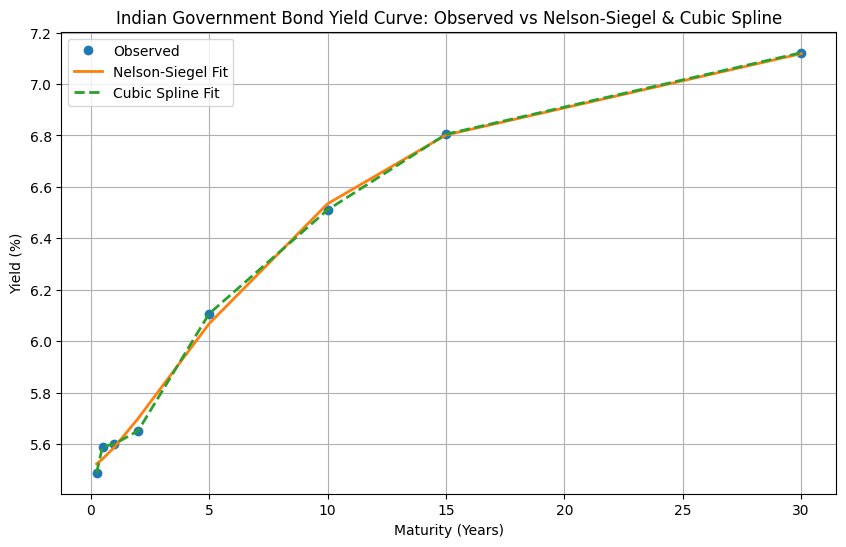

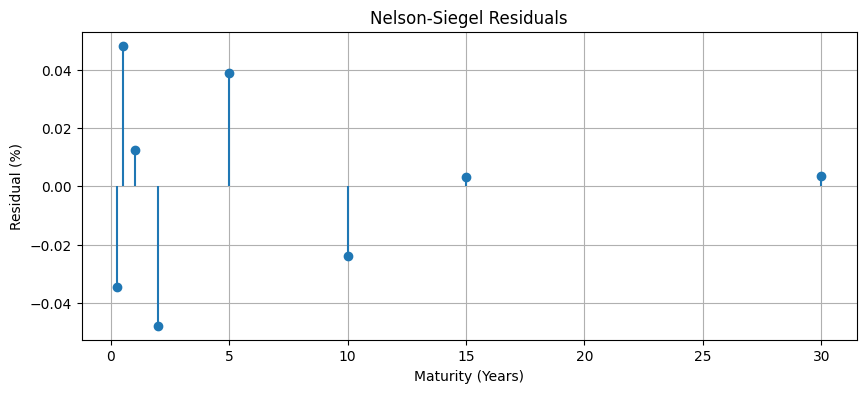

In [29]:
import matplotlib.pyplot as plt

# Nelson-Siegel fitted values
y_fit_ns = nelson_siegel(yield_curve["Years"].values, *params)

# Cubic Spline fitted values
from scipy.interpolate import CubicSpline
cs = CubicSpline(yield_curve["Years"].values, yield_curve["YTM (%)"].values)
y_fit_cs = cs(yield_curve["Years"].values)

# Residuals for Nelson-Siegel
residuals_ns = yield_curve["YTM (%)"].values - y_fit_ns

# Plot observed vs fits
plt.figure(figsize=(10,6))
plt.plot(yield_curve["Years"], yield_curve["YTM (%)"], 'o', label='Observed', markersize=6)
plt.plot(yield_curve["Years"], y_fit_ns, '-', label='Nelson-Siegel Fit', linewidth=2)
plt.plot(yield_curve["Years"], y_fit_cs, '--', label='Cubic Spline Fit', linewidth=2)

plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Indian Government Bond Yield Curve: Observed vs Nelson-Siegel & Cubic Spline")
plt.grid(True)
plt.legend()
plt.show()

# Plot residuals for Nelson-Siegel
plt.figure(figsize=(10,4))
plt.stem(yield_curve["Years"], residuals_ns, basefmt=" ")
plt.xlabel("Maturity (Years)")
plt.ylabel("Residual (%)")
plt.title("Nelson-Siegel Residuals")
plt.grid(True)
plt.show()

